In [1]:
!pip install mne numpy matplotlib scipy 



Processing file 1: 2025-04-29_006.snirf
Loading C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_006\2025-04-29_006.snirf
Reading 0 ... 3145  =      0.000 ...   309.153 secs...
  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 309.15 seconds
  Found 27 annotations in the file.
  Processed 27 annotations with calculated durations.
  Applying TDDR motion correction...
    TDDR applied successfully.
  Applying FIR filter (0.01 Hz - 0.5 Hz)...
    FIR filter applied.
  ✓ File processed successfully

Processing file 2: 2025-04-29_002.snirf
Loading C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_002\2025-04-29_002.snirf
Reading 0 ... 2343  =      0.000 ...   230.317 secs...
  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 230.32 seconds
  Found 18 annotations in the file.
  Processed 18 annotations with calculated durations.
  Applying TDDR motion correction...
    TDDR applied successf

C:\Users\PC\AppData\Local\Temp\ipykernel_13848\2397739128.py:106: RuntimeWarning: filter_length (3359) is longer than the signal (3146), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od.filter(
C:\Users\PC\AppData\Local\Temp\ipykernel_13848\2397739128.py:106: RuntimeWarning: filter_length (3359) is longer than the signal (2344), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od.filter(


Reading 0 ... 2231  =      0.000 ...   219.307 secs...
  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 219.31 seconds
  Found 17 annotations in the file.
  Processed 17 annotations with calculated durations.
  Applying TDDR motion correction...
    TDDR applied successfully.
  Applying FIR filter (0.01 Hz - 0.5 Hz)...
    FIR filter applied.
  ✓ File processed successfully

Processing file 4: 2025-04-29_004.snirf
Loading C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_004\2025-04-29_004.snirf
Reading 0 ... 2241  =      0.000 ...   220.290 secs...
  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 220.29 seconds
  Found 18 annotations in the file.
  Processed 18 annotations with calculated durations.
  Applying TDDR motion correction...
    TDDR applied successfully.
  Applying FIR filter (0.01 Hz - 0.5 Hz)...
    FIR filter applied.
  ✓ File processed successfully

Processing file 5: 2025-04-29_005.snir

C:\Users\PC\AppData\Local\Temp\ipykernel_13848\2397739128.py:106: RuntimeWarning: filter_length (3359) is longer than the signal (2232), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od.filter(
C:\Users\PC\AppData\Local\Temp\ipykernel_13848\2397739128.py:106: RuntimeWarning: filter_length (3359) is longer than the signal (2242), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od.filter(


  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 213.70 seconds
  Found 18 annotations in the file.
  Processed 18 annotations with calculated durations.
  Applying TDDR motion correction...
    TDDR applied successfully.
  Applying FIR filter (0.01 Hz - 0.5 Hz)...
    FIR filter applied.
  ✓ File processed successfully

Processing file 6: 2025-04-29_007.snirf
Loading C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_007\2025-04-29_007.snirf
Reading 0 ... 2238  =      0.000 ...   219.995 secs...
  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 220.00 seconds
  Found 18 annotations in the file.
  Processed 18 annotations with calculated durations.
  Applying TDDR motion correction...
    TDDR applied successfully.
  Applying FIR filter (0.01 Hz - 0.5 Hz)...
    FIR filter applied.
  ✓ File processed successfully

Processing file 7: 2025-05-12_001.snirf
Loading C:\Users\PC\Downloads\drive-download-20250515

C:\Users\PC\AppData\Local\Temp\ipykernel_13848\2397739128.py:106: RuntimeWarning: filter_length (3359) is longer than the signal (2175), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od.filter(
C:\Users\PC\AppData\Local\Temp\ipykernel_13848\2397739128.py:106: RuntimeWarning: filter_length (3359) is longer than the signal (2239), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od.filter(


  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 214.69 seconds
  Found 18 annotations in the file.
  Processed 18 annotations with calculated durations.
  Applying TDDR motion correction...
    TDDR applied successfully.
  Applying FIR filter (0.01 Hz - 0.5 Hz)...
    FIR filter applied.
  ✓ File processed successfully

Processing file 8: 2025-05-12_002.snirf
Loading C:\Users\PC\Downloads\drive-download-20250515T091320Z-1-001\2025-05-12_002\2025-05-12_002.snirf
Reading 0 ... 2100  =      0.000 ...   206.430 secs...
  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 206.43 seconds
  Found 18 annotations in the file.
  Processed 18 annotations with calculated durations.
  Applying TDDR motion correction...
    TDDR applied successfully.
  Applying FIR filter (0.01 Hz - 0.5 Hz)...
    FIR filter applied.
  ✓ File processed successfully

Processing file 9: 2025-05-12_003.snirf
Loading C:\Users\PC\Downloads\drive-download-20250515

C:\Users\PC\AppData\Local\Temp\ipykernel_13848\2397739128.py:106: RuntimeWarning: filter_length (3359) is longer than the signal (2185), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od.filter(
C:\Users\PC\AppData\Local\Temp\ipykernel_13848\2397739128.py:106: RuntimeWarning: filter_length (3359) is longer than the signal (2101), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od.filter(


Reading 0 ... 2057  =      0.000 ...   202.203 secs...
  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 202.20 seconds
  Found 18 annotations in the file.
  Processed 18 annotations with calculated durations.
  Applying TDDR motion correction...
    TDDR applied successfully.
  Applying FIR filter (0.01 Hz - 0.5 Hz)...
    FIR filter applied.
  ✓ File processed successfully

Processing file 10: 2025-05-12_004.snirf
Loading C:\Users\PC\Downloads\drive-download-20250515T091320Z-1-001\2025-05-12_004\2025-05-12_004.snirf
Reading 0 ... 2187  =      0.000 ...   214.982 secs...
  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 214.98 seconds
  Found 18 annotations in the file.
  Processed 18 annotations with calculated durations.
  Applying TDDR motion correction...
    TDDR applied successfully.
  Applying FIR filter (0.01 Hz - 0.5 Hz)...
    FIR filter applied.
  ✓ File processed successfully

Processing file 11: 2025-05-12_005.sn

C:\Users\PC\AppData\Local\Temp\ipykernel_13848\2397739128.py:106: RuntimeWarning: filter_length (3359) is longer than the signal (2058), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od.filter(
C:\Users\PC\AppData\Local\Temp\ipykernel_13848\2397739128.py:106: RuntimeWarning: filter_length (3359) is longer than the signal (2188), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od.filter(


  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 123.86 seconds
  Found 10 annotations in the file.
  Processed 10 annotations with calculated durations.
  Applying TDDR motion correction...
    TDDR applied successfully.
  Applying FIR filter (0.01 Hz - 0.5 Hz)...
    FIR filter applied.
  ✓ File processed successfully

Processing file 12: 2025-05-12_007.snirf
Loading C:\Users\PC\Downloads\drive-download-20250515T091320Z-1-001\2025-05-12_007\2025-05-12_007.snirf
Reading 0 ... 1358  =      0.000 ...   133.491 secs...
  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 133.49 seconds
  Found 10 annotations in the file.
  Processed 10 annotations with calculated durations.
  Applying TDDR motion correction...
    TDDR applied successfully.
  Applying FIR filter (0.01 Hz - 0.5 Hz)...
    FIR filter applied.
  ✓ File processed successfully

Processing file 13: 2025-05-12_008.snirf
Loading C:\Users\PC\Downloads\drive-download-202505

C:\Users\PC\AppData\Local\Temp\ipykernel_13848\2397739128.py:106: RuntimeWarning: filter_length (3359) is longer than the signal (1261), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od.filter(
C:\Users\PC\AppData\Local\Temp\ipykernel_13848\2397739128.py:106: RuntimeWarning: filter_length (3359) is longer than the signal (1359), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od.filter(


  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 125.63 seconds
  Found 10 annotations in the file.
  Processed 10 annotations with calculated durations.
  Applying TDDR motion correction...
    TDDR applied successfully.
  Applying FIR filter (0.01 Hz - 0.5 Hz)...
    FIR filter applied.
  ✓ File processed successfully

Processing file 14: 2025-05-14_002.snirf
Loading C:\Users\PC\Downloads\drive-download-20250515T091731Z-1-001\2025-05-14_002\2025-05-14_002.snirf
Reading 0 ... 1298  =      0.000 ...   127.593 secs...
  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 127.59 seconds
  Found 10 annotations in the file.
  Processed 10 annotations with calculated durations.
  Applying TDDR motion correction...
    TDDR applied successfully.
  Applying FIR filter (0.01 Hz - 0.5 Hz)...
    FIR filter applied.
  ✓ File processed successfully

Processing file 15: 2025-05-14_003.snirf
Loading C:\Users\PC\Downloads\drive-download-202505

C:\Users\PC\AppData\Local\Temp\ipykernel_13848\2397739128.py:106: RuntimeWarning: filter_length (3359) is longer than the signal (1279), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od.filter(
C:\Users\PC\AppData\Local\Temp\ipykernel_13848\2397739128.py:106: RuntimeWarning: filter_length (3359) is longer than the signal (1299), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od.filter(


  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 126.22 seconds
  Found 10 annotations in the file.
  Processed 10 annotations with calculated durations.
  Applying TDDR motion correction...
    TDDR applied successfully.
  Applying FIR filter (0.01 Hz - 0.5 Hz)...
    FIR filter applied.
  ✓ File processed successfully

All processed files have consistent sampling frequency: 10.172939979654121 Hz

Attempting to merge processed files...
Files merged successfully.

Annotations in the combined file:
1. 'Right_hand_lift' - start: 6.09s, duration: 10.03s
2. 'Rest' - start: 16.12s, duration: 10.03s
3. 'Rest' - start: 26.15s, duration: 12.98s
4. 'Right_hand_lift' - start: 39.12s, duration: 13.07s
5. 'Rest' - start: 52.20s, duration: 11.01s
6. 'Left_hand_lift' - start: 63.21s, duration: 11.01s
7. 'Rest' - start: 74.22s, duration: 8.95s
8. 'Left_hand_lift' - start: 83.17s, duration: 13.07s
9. 'Rest' - start: 96.24s, duration: 12.09s
10. 'Left_hand_lift' - start: 

C:\Users\PC\AppData\Local\Temp\ipykernel_13848\2397739128.py:106: RuntimeWarning: filter_length (3359) is longer than the signal (1285), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od.filter(


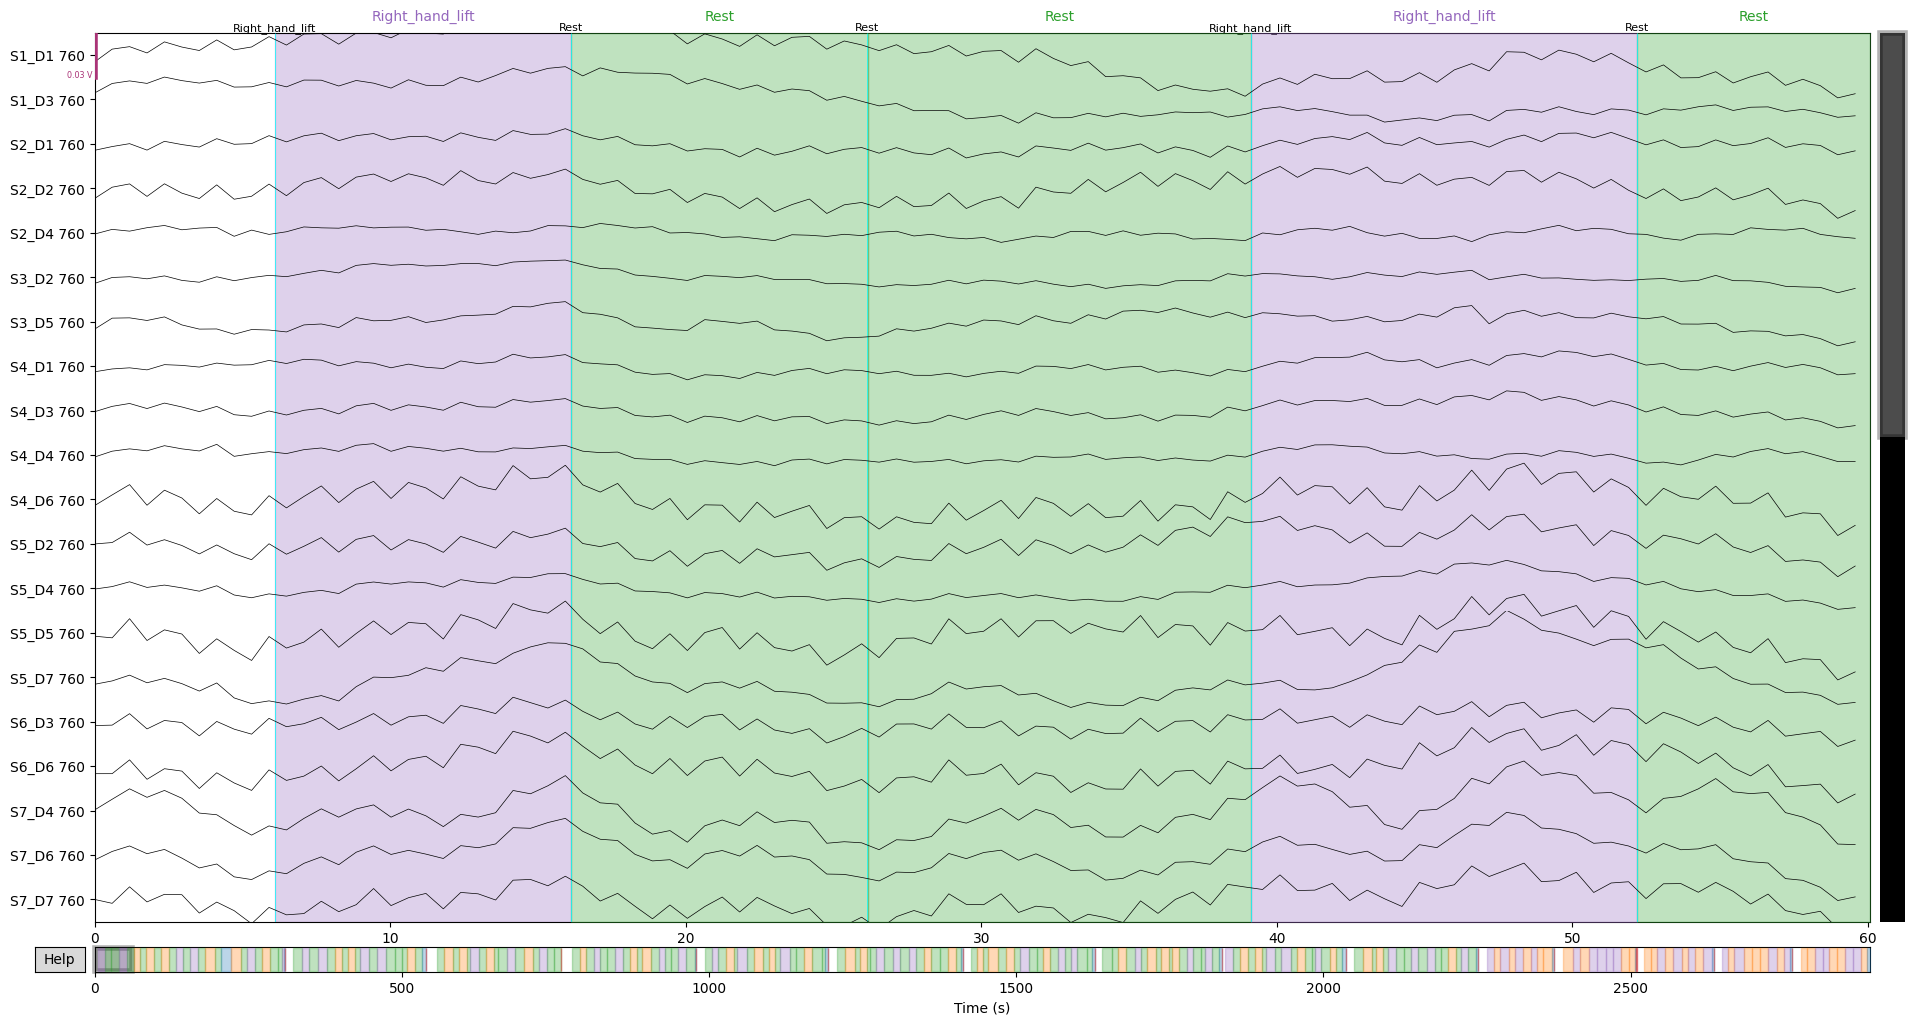

Writing c:\Users\PC\OneDrive - Universidad de Deusto\Documentos\nirs_web_app\nirs-analysis-backend\uploads\Combined_NIRS_Data_TDDR_Filtered_raw.fif.gz
Closing c:\Users\PC\OneDrive - Universidad de Deusto\Documentos\nirs_web_app\nirs-analysis-backend\uploads\Combined_NIRS_Data_TDDR_Filtered_raw.fif.gz
[done]

Combined file saved successfully to 'nirs-analysis-backend/uploads/Combined_NIRS_Data_TDDR_Filtered_raw.fif.gz'!


In [ ]:
import os
import traceback
import mne
import numpy as np
import matplotlib.pyplot as plt
from mne.preprocessing.nirs import (
    optical_density,
    temporal_derivative_distribution_repair,
)
# Paths to the .snirf files
file_paths = [
    r'C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_006\2025-04-29_006.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_002\2025-04-29_002.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_003\2025-04-29_003.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_004\2025-04-29_004.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_005\2025-04-29_005.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_007\2025-04-29_007.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250515T091320Z-1-001\2025-05-12_001\2025-05-12_001.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250515T091320Z-1-001\2025-05-12_002\2025-05-12_002.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250515T091320Z-1-001\2025-05-12_003\2025-05-12_003.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250515T091320Z-1-001\2025-05-12_004\2025-05-12_004.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250515T091320Z-1-001\2025-05-12_005\2025-05-12_005.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250515T091320Z-1-001\2025-05-12_007\2025-05-12_007.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250515T091320Z-1-001\2025-05-12_008\2025-05-12_008.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250515T091731Z-1-001\2025-05-14_002\2025-05-14_002.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250515T091731Z-1-001\2025-05-14_003\2025-05-14_003.snirf',
]

# Mapping from original annotation descriptions (expected in SNIRF) to desired event names
annotation_description_map = {
    '1': 'Left_hand_lift', 
    '2': 'Rest',             
    '3': 'Right_hand_lift' 
}

# List to store processed data
processed_raws = []

# Process each file
for i, file_path in enumerate(file_paths):
    file_name = os.path.basename(file_path)
    print(f"\nProcessing file {i+1}: {file_name}")

    try:
        # Load the SNIRF file
        raw = mne.io.read_raw_snirf(file_path, preload=True)
        print(f"  Sampling frequency: {raw.info['sfreq']} Hz")
        print(f"  Channels: {len(raw.info['ch_names'])} channels")
        print(f"  Duration: {raw.times[-1]:.2f} seconds")

        # Process existing annotations to define event durations
        if raw.annotations and len(raw.annotations) > 0:
            print(f"  Found {len(raw.annotations)} annotations in the file.")
            new_onsets = []
            new_durations = []
            new_descriptions = []
            sorted_annotations = sorted(raw.annotations, key=lambda x: x['onset'])

            for j, annot in enumerate(sorted_annotations):
                original_desc = str(annot['description'])
                mapped_desc = annotation_description_map.get(original_desc, original_desc)
                current_onset = annot['onset']
                
                if j < len(sorted_annotations) - 1:
                    duration = sorted_annotations[j+1]['onset'] - current_onset
                else:
                    duration = raw.times[-1] - current_onset
                
                if duration > 0:
                    new_onsets.append(current_onset)
                    new_durations.append(duration)
                    new_descriptions.append(mapped_desc)
                else:
                    print(f"    Skipping annotation '{original_desc}' at {current_onset:.2f}s due to zero or negative duration.")

            if new_onsets:
                processed_annotations = mne.Annotations(onset=np.array(new_onsets),
                                                        duration=np.array(new_durations),
                                                        description=new_descriptions)
                raw.set_annotations(processed_annotations)
                print(f"  Processed {len(processed_annotations)} annotations with calculated durations.")
            else:
                print("  WARNING: No valid annotations with positive duration found after processing.")
        else:
            print("  WARNING: No annotations found in the file. Cannot define events.")
            # Consider skipping this file if annotations are crucial:
            # print(f"  Skipping file {file_name} due to missing annotations.")
            # continue 
            
        # Convert to optical density
        raw_od = optical_density(raw)

        # Apply TDDR for motion correction
        print("  Applying TDDR motion correction...")
        try:
           # raw_od = temporal_derivative_distribution_repair(raw_od)
            print("    TDDR applied successfully.")
        except Exception as tddr_e:
            print(f"    WARNING: TDDR failed for file {file_name}: {tddr_e}")
            print("    Proceeding without TDDR for this file.")

        # Filter using FIR (Fourier-based)
        print("  Applying FIR filter (0.01 Hz - 0.5 Hz)...")
        try:
            raw_od.filter(
                0.01, 0.5, picks='fnirs', method='fir', fir_design='firwin',
                filter_length='auto', verbose=False
            )
            print("    FIR filter applied.")
        except Exception as filter_e:
            print(f"    WARNING: FIR filter failed for file {file_name}: {filter_e}")
            print("    Trying with IIR filter as fallback...")
            try:
                raw_od.filter(
                    0.01, 0.5, picks='fnirs', method='iir', verbose=False
                )
                print("    IIR filter applied as fallback.")
            except Exception as iir_e:
                print(f"    ERROR: Both FIR and IIR filters failed for file {file_name}: {iir_e}")
                continue
        # Add to the list of processed
        processed_raws.append(raw_od)
        print(f"  ✓ File processed successfully")

    except Exception as e:
        print(f"  ERROR processing file {file_name}: {e}")
        traceback.print_exc()

# Check if there is processed data before continuing
if not processed_raws:
    raise ValueError("No files were successfully processed to combine.")

# Check if sampling frequencies are the same and resample if necessary
sfreqs = [r.info['sfreq'] for r in processed_raws]
if len(set(sfreqs)) > 1:
    target_sfreq = min(sfreqs)
    print(f"\nWARNING: Sampling frequencies differ {sfreqs}. Resampling all to {target_sfreq} Hz.")
    for k_idx, r_item in enumerate(processed_raws): # Use enumerate for index
        if r_item.info['sfreq'] != target_sfreq:
            # Provide more context for which file is being resampled
            # This assumes processed_raws items correspond to file_paths items by order
            original_file_name_for_resample = os.path.basename(file_paths[k_idx]) if k_idx < len(file_paths) else f"Item {k_idx+1}"
            print(f"  Resampling {original_file_name_for_resample} (index {k_idx+1}) from {r_item.info['sfreq']} Hz to {target_sfreq} Hz...")
            processed_raws[k_idx].resample(target_sfreq, npad='auto', verbose=False)
elif not sfreqs:
     raise ValueError("Could not determine sampling frequencies for processed files.")
else:
    print(f"\nAll processed files have consistent sampling frequency: {sfreqs[0]} Hz")

# Merge the files
print("\nAttempting to merge processed files...")
merged_raw = mne.concatenate_raws(processed_raws, preload=True, verbose=False)
print("Files merged successfully.")

# Visualize the resulting annotations
print("\nAnnotations in the combined file:")
if merged_raw.annotations and len(merged_raw.annotations) > 0:
    for k_annot, annot_item in enumerate(merged_raw.annotations): # Use enumerate for index
        print(f"{k_annot+1}. '{annot_item['description']}' - start: {annot_item['onset']:.2f}s, duration: {annot_item['duration']:.2f}s")

    # Visualize the events in the combined file
    try:
        events, event_id_map = mne.events_from_annotations(merged_raw)
        print("\nEvent ID map for plotting:", event_id_map)
        plot_duration = min(60, merged_raw.times[-1]) 
        fig = merged_raw.plot(events=events,
                               event_id=event_id_map,
                               duration=plot_duration, 
                               scalings='auto',
                               title='Events in combined data',
                               show_scrollbars=True,
                               block=False) 
        plt.show()
    except Exception as e:
         print(f"\nCould not plot events: {e}")
         traceback.print_exc()
else:
    print("No annotations found in the merged file.")

# Save the merged file in .fif format (compressed)
output_dir = 'nirs-analysis-backend/uploads/' 
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created output directory: {output_dir}")

output_path = os.path.join(output_dir, 'Combined_NIRS_Data_TDDR_Filtered_raw.fif.gz') # Updated name
merged_raw.save(output_path, overwrite=True)
print(f"\nCombined file saved successfully to '{output_path}'!")
